In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
from StoSpecRep.waveletEPSD import CWTx
from StoSpecRep.console import console
from DL_recons_pckg.SpecRepMethod import SRM

2022-11-01 15:02:47.890027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

**A failed attempt to get data from url**

In [4]:
# data = pd.read_csv('http://www.vibrationdata.com/elcentro_NS.dat')

# response = requests.get('http://www.vibrationdata.com/elcentro_NS.dat')
# data = response.content

## pull up the test

In [5]:
NS_acc = np.loadtxt('../test_data/elcentro_NS.txt')

In [6]:
NS_acc.shape

(2688, 2)

In [7]:
NS_acc[-1, 0]

53.74

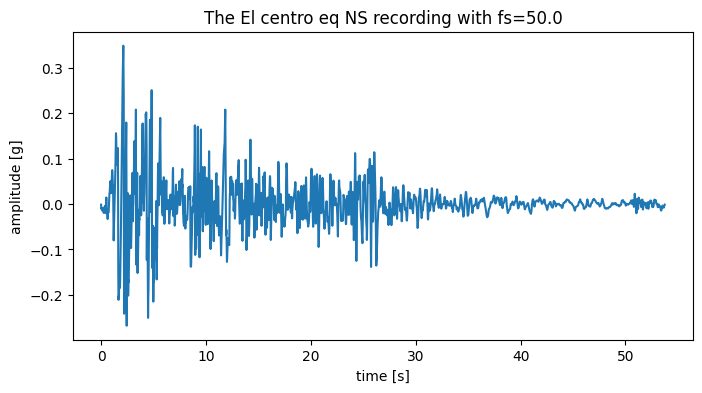

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(NS_acc[:, 0], NS_acc[:, 1])
ax.set_xlabel('time [s]')
ax.set_ylabel('amplitude [g]')
dt = NS_acc[100, 0] - NS_acc[99, 0]
ax.set_title(f"The El centro eq NS recording with fs={np.ceil(1/dt)}")
plt.show()

## create an `CWTx` object

In [9]:
Elcentro_obj = CWTx(signal=NS_acc[:, 1], fs=50, t_axis=NS_acc[:, 0])

In [10]:
console.print(Elcentro_obj.freqhelper(CWTx.goto_scales))

FreqRange(low=0.0396728515625, high=10.15625)

In [11]:
Elcentro_obj.check_scales(a=2, b=8, num=900)

(a=2,b=8) ==> scales_range(4.0, 256.0) ==> FreqRange(low=0.15869140625, high=10.15625)

**Hint:**

N_total = time_duration * fs

Let's say we use `duration` in seconds

Then I need a t_axis

Actually I think 'N' is simpler ....

In [12]:
# propose scales to use
Elcentro_obj.propose_scales(a=2, b=8, num=900)

You've proposed scales:

(a=2,b=8) ==> scales_range(4.0, 256.0) ==> FreqRange(low=0.15869140625, high=10.15625)

#### Focus on the wavelet results (EPSD, f, t)

> EPSD

In [13]:
# compute EPSD by wavelet transform
Elcentro_obj.computeEPSD()

In [14]:
Elcentro_obj._pwr_coef.shape

(900, 2688)

> frequency array

In [15]:
len(Elcentro_obj._freqs)

900

> frequency resolution: $\Delta_{\omega}$

In [16]:
# delta_f = np.append(arr=np.diff(freq_range),  values=np.diff(freq_range)[-1])

> time axis

In [17]:
Elcentro_obj.t_axis.shape

(2688,)

#### See the EPSD

(0.0, 10.0)

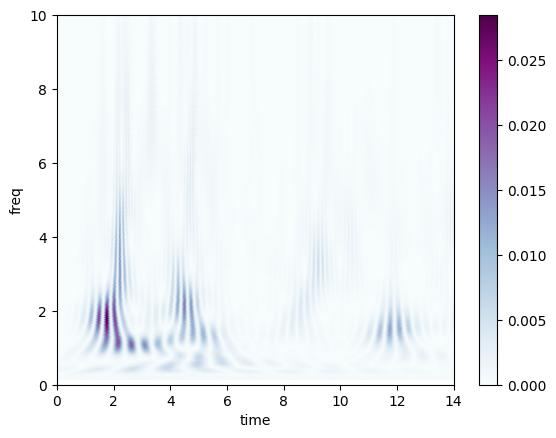

In [18]:
Elcentro_obj.plot_waveletEPSD(option='2d')
plt.xlim(0, 14)
plt.ylim(0, 10)

(0.0, 0.05)

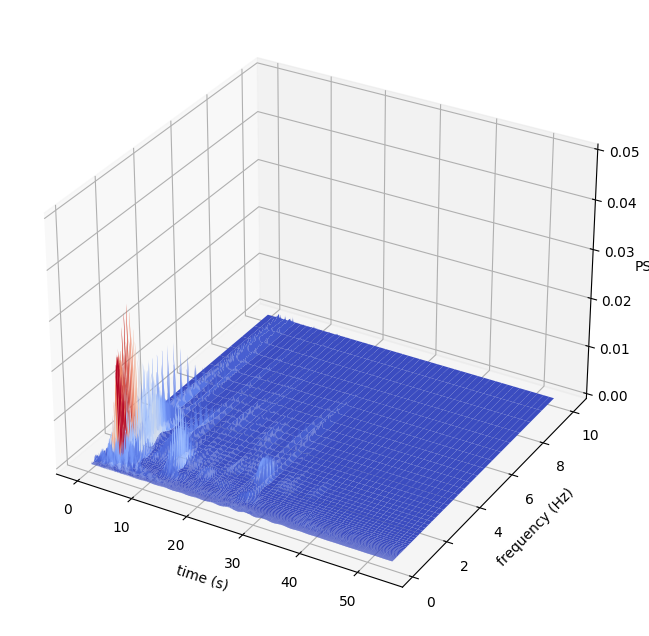

In [55]:
Elcentro_obj.plot_waveletEPSD(option='3d')
ax = plt.gca()
ax.set_zlim3d(0, 0.05)
# ax.set_xlim3d(left=0, right=14)
# ax.set_ylim(bottom=0, top=10)

#### Get the simulation

In [20]:
# # alright, let's write up a general function that takes (Stw, w, t) 
# def SRM_formula(Stw, f_vec, t_vec):
#     """ Redo the SRM based on a computed wavelet EPSD 
    
#     Hint: 
#     ----
#     Swt    --> obj._pwr_coef.shape
#     f_vec  --> obj._freqs
#     t_vec  --> obj.t_axis
#     """
    
#     # entry
#     N1 = len(f_vec)
#     w_vec = 2 * np.pi * f_vec
#     phi_n = np.random.uniform(0, 2 * np.pi, N1)
#     delta_f = np.abs(np.append(arr=np.diff(f_vec),  values=np.diff(f_vec)[-1]))
#     delta_w  = 2 * np.pi * delta_f
    
#     # main course
#     sum = 0
#     for i in range(1, N1):
#         sum = sum + np.sqrt(4 * Stw[i] * delta_w[i]) * np.cos(w_vec[i] * t_vec + phi_n[i])
#     return sum

# trial_simulation = SRM_formula(
#         Stw=Elcentro_obj._pwr_coef, 
#         f_vec=Elcentro_obj._freqs, 
#         t_vec=Elcentro_obj.t_axis)

In [40]:
trial_simulation = Elcentro_obj.g_a_SRMsimu()

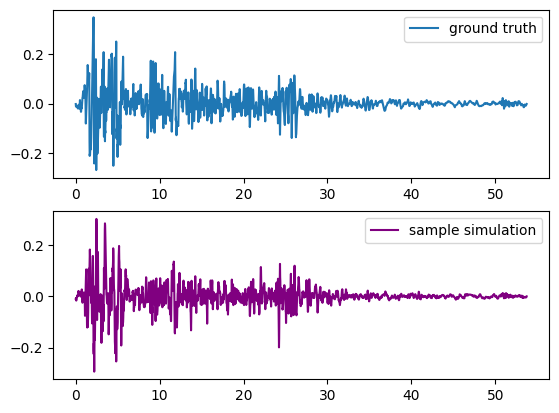

In [41]:
fig, (ax0, ax1) =plt.subplots(nrows=2, ncols=1)

ax0.plot(NS_acc[:, 0], NS_acc[:, 1], label='ground truth')
ax0.legend()
ax1.plot(Elcentro_obj.t_axis, trial_simulation, color='purple', label='sample simulation')
ax1.legend()

In [51]:
ensemble_simus = Elcentro_obj.g_ensemble_simus(20)

In [52]:
ensemble_simus.shape

(20, 2688)

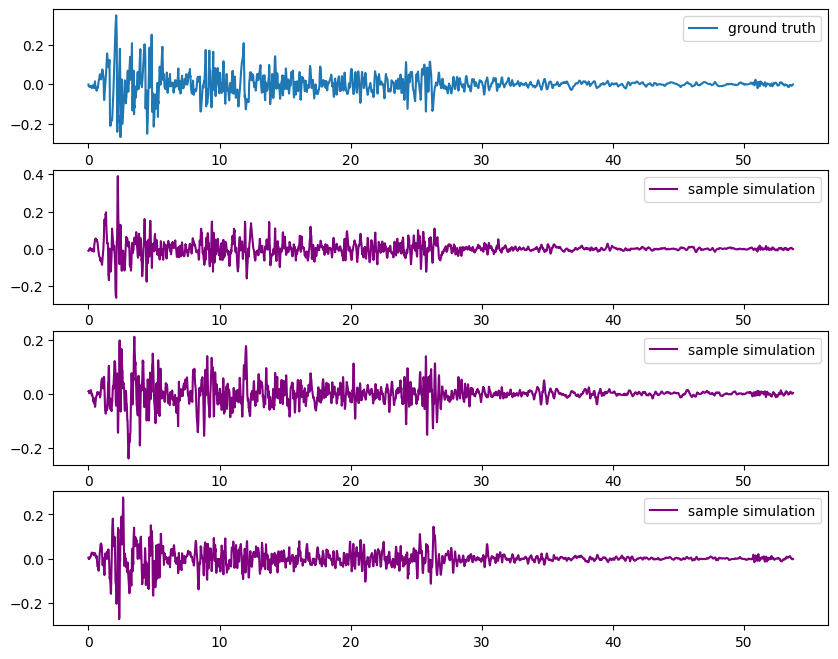

In [54]:
fig, (ax0, ax1, ax2, ax3) =plt.subplots(nrows=4, ncols=1, figsize=(10, 8))

ax0.plot(NS_acc[:, 0], NS_acc[:, 1], label='ground truth')
ax0.legend()

ax1.plot(Elcentro_obj.t_axis, ensemble_simus[0], color='purple', label='sample simulation')
ax1.legend()
ax2.plot(Elcentro_obj.t_axis, ensemble_simus[3], color='purple', label='sample simulation')
ax2.legend()
ax3.plot(Elcentro_obj.t_axis, ensemble_simus[6], color='purple', label='sample simulation')
ax3.legend()
plt.show()

### okay, below it shows the old way ... something wrong with the it

In [ ]:
# maybe I can just pass along N

Elcentro_simu_obj = SRM(
        wu=(50/2)*2*np.pi, 
        N1=50, 
        fs=50, 
        duration=50)

In [ ]:
console.print(Elcentro_simu_obj)

In [ ]:
raw_esmble_gens2_wavelet =  Elcentro_simu_obj.nonsta_esmb_simus(
        Pxx=Elcentro_obj._pwr_coef, 
        freqs=Elcentro_obj._freqs, 
        t_bins=Elcentro_obj.t_axis, 
        ensemble_num=50)

In [ ]:
len(raw_esmble_gens2_wavelet[0])

In [ ]:
plt.close('all')

In [ ]:
fig, (ax0, ax1) =plt.subplots(nrows=2, ncols=1)

ax0.plot(NS_acc[:, 0], NS_acc[:, 1])
ax1.plot(Elcentro_obj.t_axis[:2500], raw_esmble_gens2_wavelet[1])

In [ ]:
# dig into details ...
interpolated_Swt = Elcentro_simu_obj._interpo_spectra(
        Pxx=Elcentro_obj._pwr_coef, 
        freqs=Elcentro_obj._freqs, 
        t_bins=Elcentro_obj.t_axis)

In [ ]:
interpolated_Swt.shape